# PROSJEKT 2 _____________________

# Ship Stability blabla


**TING Å ORDNE**
- likningsreferanse funker nå bare i samme celle... Gamlemåten?

- Laste opp gifs på nett og sette inn lenker!!!!!!!!!

- update figure count

- add text to all figures




## Contents
* [Introduction](#intro)
* [Theory behind methods](#method)
* [Model and assumptions](#model)
* [Code for visualization](#vis)
* [Harmonic oscillator with constant $A$](#constA)
* [Varying the displaced-water-area](#water)
* [Boat with cargo](#cargo)
* [Boat with friction and harmonic wave/wind-force](#w-force)
* [](#)
* [Conclusion](#conclusion)

## Introduction <a class="anchor" id="intro"></a>

In this project we will study \\

\

\

\

Adding ... to the model \\
\\
\\



A note on figures and animations??? Vi får se hvor hard vi blir slakta for sånn vi gjorde det sist. 

In [88]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Theory behind methods <a class="anchor" id="method"></a>

**HVIS VI FØLER DET ER BEDRE Å SAMLE DET LITT OG REFERERE SENERE???**

In [89]:
## Libraries for maths and plotting
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm

## Library for status bar
from tqdm.notebook import tqdm

**Newtons method**



In [90]:
# 1a
def newton(f, df, x0, tol=1.e-10, max_iter=30, variable = "x"):
    """
    brief: Solves the equation f(x)=0 with Newtons method
    :param f: the function f(x)
    :param df: the derivative of f(x)
    :param x0: initial value
    :param tol: tolerance, if f(x)<tol we accept x
    :return: the accepted root, number of iterations
    """
    x = x0
    for k in range(max_iter):
        print(f"k ={k:3d}, {variable} = {x:18.15f}, f(x) = {f(x):10.3e}")
        fx = f(x)
        if norm(fx) < tol: # Accept solution 
            break 
        x = x - fx/df(x)   # One Newton-iteration
    return x, k+1

## Model and assumptions <a class="anchor" id="model"></a>

**The ship and its parameters**

We will assume that the ship is long enough to neglect effects on its ends, and we are left with a two dimentional problem. We let the ship have the shape of a half-sircle with the radius $R=10 \textrm{ m}$, and give it a uniform mass distribution with density $\sigma = 500 \textrm{ kg/m}^2$. For such a shape the mass centre $C$ lies a distance 

$$ h_{CM} = 4R/3\pi, $$

below the ship's metacentre $M$. The moment of inertia about $C$ is given by:

$$I_C = \frac{1}{2} m R^2 \left( 1-\frac{32}{9\pi^2} \right).$$

<a id="fig1"></a>


<div>
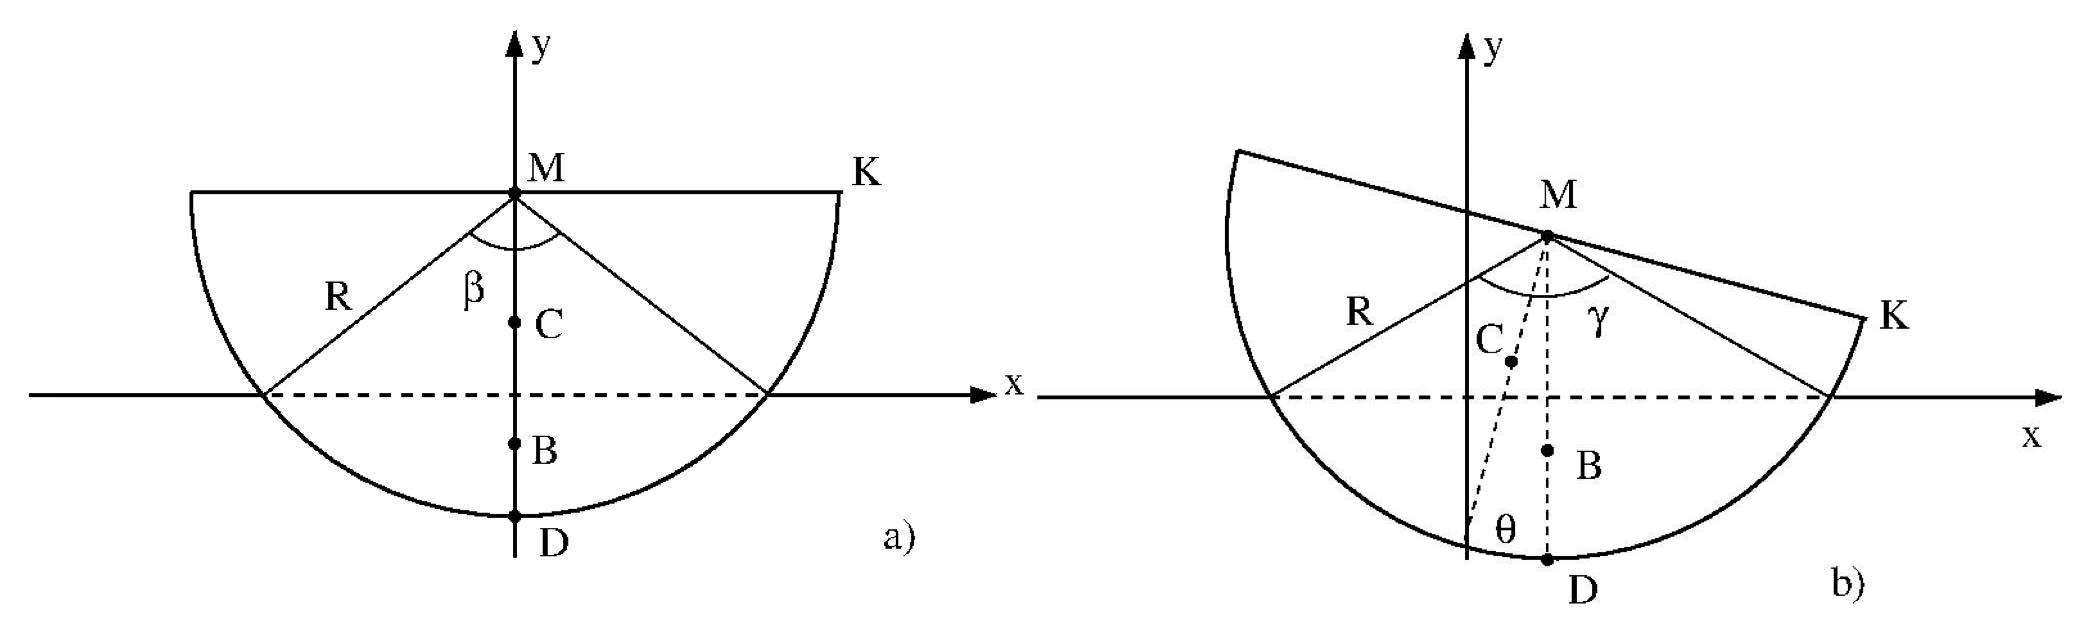
</div>


***Figure 1*** *: A sketch of our boat-model. a) The boat in equilibrium. b) The boat after displacement and rotation about the centre of mass, $C$.*




With Arkimedes law we can show that the ship, in equillibrium, displaces an area $A_0$ of water:

$$A_0 = \sigma \pi R^2 / 2 \sigma_0.$$

As the ship rotates about $C$ the amount of displaced water varies. We introduce the angle $\gamma$ shown in **ref**, and let $\gamma_{\textrm{equil}} = \beta$. Some geometry gives us the displaced-water-area $A$ in terms of $\gamma$: 

$$A = \frac{1}{2} R^2 (\gamma - \sin{\gamma}).$$

In [91]:
## Defining constants that will remain the same
sigma_0 = 1000
sigma   = 500
R       = 10
A_s     = 1/2*np.pi*R**2
g       = 9.81
h_CM    = 4*R/(3*np.pi)
m       = sigma * A_s         # mass of one metre boat 
I_C     = 1/2*m*R**2*(1 - 32/(9*np.pi**2))

In [92]:
def find_A(gamma):
    return 1/2*R**2*(gamma-np.sin(gamma))

At $\gamma=\beta$ we have $A=A_0$ giving an implicit equation for $\beta$:

$$
\begin{align}
f(\beta) &= \beta - \sin {\beta} - \pi \sigma / \sigma_0 = 0.
\end{align}
$$

We will solve this equation by Newtons method. As discussed in **REF METHODS ...** we need the derivative:

$$f'(\beta) = 1 - \cos{\beta}.$$

k =  0, β =  2.000000000000000, f(x) = -4.801e-01
k =  1, β =  2.339014105903838, f(x) =  4.907e-02
k =  2, β =  2.310063196572691, f(x) =  3.042e-04
k =  3, β =  2.309881467301467, f(x) =  1.220e-08
k =  4, β =  2.309881460010057, f(x) =  4.441e-16


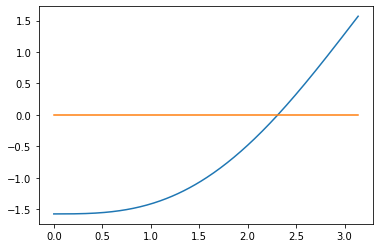

In [93]:
def find_beta_newton(b0, plot = False):
    def f(b):
        return b - np.sin(b) - np.pi*sigma/sigma_0
    def df(b):
        return 1 - np.cos(b)
    beta = newton(f, df, b0, variable = "\u03B2")[0]
    if plot:
        x = np.arange(0, np.pi, 0.01)
        plt.plot(x, f(x))
        plt.plot(x, 0*x)
    return beta

beta = find_beta_newton(2, plot = True)

***DISCUSS CONVERGENCE??***

**Points on the ship**

An important point is the centre of the buoyant force, $B$, wich lies a distance $Y_{MB}$ below $M$:

$$Y_{MB} = R\cdot \frac{4 \sin^3{\gamma/2}}{3(\gamma - \sin{\gamma})}.$$

In [94]:
def find_yMB(gamma):
    return R*4*np.sin(gamma/2)**3 / (3*(gamma - np.sin(gamma)))

When solving the motion of the boat we will keep track of $\theta$ and $y_C$. We shall see that $\gamma$ is determined by these two values. Always knowing $\gamma$ means we can also compute $y_M$, $y_B$ and $y_D$. If we let $y=0$ at the water level, we have:

$$
\begin{align*}
y_M (\theta, y_C) &= R \cos{\gamma/2} \\
y_B (\theta, y_C) &= y_M - Y_{MB}(\gamma) \\
y_D (\theta, y_C) &= y_M - R.
\end{align*}
$$

The points $M$, $B$ and $D$ lie on the same vertical line:

$$
\begin{align*}
x_M (\theta, x_C) &= x_C + h_{CM} \sin{\theta} \\
x_B (\theta, x_C) &= x_M  \\
x_D (\theta, x_C) &= x_M.
\end{align*}
$$



In [95]:
def find_yM(gamma):
    return R*np.cos(gamma/2)
def find_yB(gamma):
    return find_yM(gamma) - find_yMB(gamma)
def find_yD(gamma):
    return find_yM(gamma) - R

def find_xMBD(theta, xC):
    return x_C + h_CM*np.sin(theta)

For a ship in equilibrium we know $\gamma = \beta$. In equilibrium $C$ lies $h_{CM}$ below $M$:

$$
\begin{align*}
y_C^0 &= y_M(\beta) - h_{CM}. \\
\end{align*}
$$

We compute the equilibrium coordinates below:

In [96]:
# 1b - definere yM0, yC0, yB0, yD0 med vannet som nullpunkt for y

yM0 = find_yM(beta)
yC0 = yM0 - h_CM
yB0 = find_yB(beta)
yD0 = find_yD(beta)

decimals = 5
print(f'yM0 = {round(yM0, decimals)} m\n')
print(f'yC0 = {round(yC0, decimals)} m\n')
print(f'yB0 = {round(yB0, decimals)} m\n')
print(f'yD0 = {round(yD0, decimals)} m')

yM0 = 4.03973 m

yC0 = -0.2044 m

yB0 = -2.45792 m

yD0 = -5.96027 m


We have seen that we need to compute $\gamma$ to find displaced water area and other important quantities. It is determined by $\theta$ and $y_C$. We have $\cos{\gamma/2}=y_M/R$. When the boat rotates $\theta$, $y_M$ moves in a circular motion about $C$ with the radius $h_{CM}$. An additional change in $y_M$ comes from the change in $y_C$. Thus we can write:

$$ \gamma (\theta, y_C)= 2\arccos{\left( \cos{\frac{\beta}{2}} - \frac{4}{3\pi}(1-\cos{\theta}) + \frac{y_C - y_C^0}{R} \right)}.$$

In [97]:
def find_gamma(theta, yC):
    return 2*np.arccos(np.cos(beta/2) - 4/(3*np.pi)*(1-np.cos(theta)) + (yC-yC0)/R)

**Forces on the ship**




Gravity acts vertically pulling the boat down with a constant force:

$$ \vec F_G = -mg \, \hat y. $$

A net buoyant force pushes the boat upwards counteracting gravity. The net force acts in the centre of buoyancy, $B$, wich would have been the mass centre of the displaced water. The force is proportional to our $\gamma$-dependent displaced area:

$$ \vec F_B = \sigma_0 A g \hat y = \frac{\sigma_0gR^2}{2} (\gamma - \sin{\gamma}) \, \hat y.$$

We will model the friction between the boat and the water as proportional to the contact-area and the velocity of the boats surface. We let the force act in horisontaly in the deepest point $D$. With our assumptions it is given by:

$$\vec f = -k_f R^2 \gamma \omega \, \hat x.$$

We model the wind/wave force as a horisontal harmonic force acting along the water:

$$F_w(t) = F_0 \cos{\omega_w t} \, \hat x$$


In [98]:
def F_G():
    return -m*g
def find_F_buoyant(displaced_area):
    return sigma_0*g*displaced_area
def find_F_friction(gamma, omega, k_f):
    return -k_f*R**2*gamma*omega
def find_F_waves_wind(t, F_0, omega_w):
    return F_0*np.cos(omega_w*t)

The torques about $C$ are found by multiplying the forces with their corresponding lever arms:

$$
\begin{align}
    \vec \tau_B &= -F_B h_{CM} \sin{\theta} \, \hat z\\
    \vec \tau_f &= f\left( y_C - R(\cos{\gamma/2}-1) \right) \, \hat z\\
    \vec \tau_w &= F_w y_C \,  \hat z
\end{align}
$$


In [99]:
def find_tau_buoyant(theta, F_B):
    return - F_B*h_CM*np.sin(theta)
def find_tau_friction(y_C, gamma, f):
    return f*(y_C - R*(np.cos(gamma/2) - 1))
def find_tau_waves_wind(y_C, F_w):
    return F_w*y_C

**Moving cargo**

*Figure and coordinate system*
distance s_L ....

In [100]:
############ FINNE UT HVA VI SKAL GJØRE HER #################

***We will assume that the cargo does not loose contact with the ship unless it slips of the edges. We will also do simulations with fences keeping the cargo from falling off. While the cargo is on the ship the forces acting from the cargo in the ship are given by:***

$$
\begin{align}
    F_{L, x} (\theta) &= m_L g \cos{\theta} \sin{\theta} 
    \tag {34a} \\
    F_{L, y} (\theta) &= - m_L g \cos^2{\theta}
    \tag {34b}
\end{align}
$$

***It follows from Newtons third law that the forces on the cargo are given by:***

$$
\begin{align}
    F_{L, x}' (\theta) &= -m_L g \cos{\theta} \sin{\theta} 
    \tag {34a} \\
    F_{L, y}' (\theta) &= m_L g \cos^2{\theta}
    \tag {34b}
\end{align}
$$

When the ship is tilted an angle $\theta$ the net force on the cargo is along the deck, and is given by:


In [101]:
def find_F_Lx(theta):
    return m_L*g*np.cos(theta)*np.sin(theta)
def find_F_Ly(theta):
    return -m_L*g*np.cos(theta)**2

$$
\vec \tau (\theta, s_L) = - m_L g \cos{\theta} s_L \hat z
$$

In [102]:
def find_tau_L(theta, s_L):
    return -m_L*g*np.cos(theta)*s_L

**Capsizing thr boat**

We say that our boat has capsized if part of the deck is below the water level. (The engineers thought it was a bright idea to have a drain into a ... INSERT JOKE).


<div>
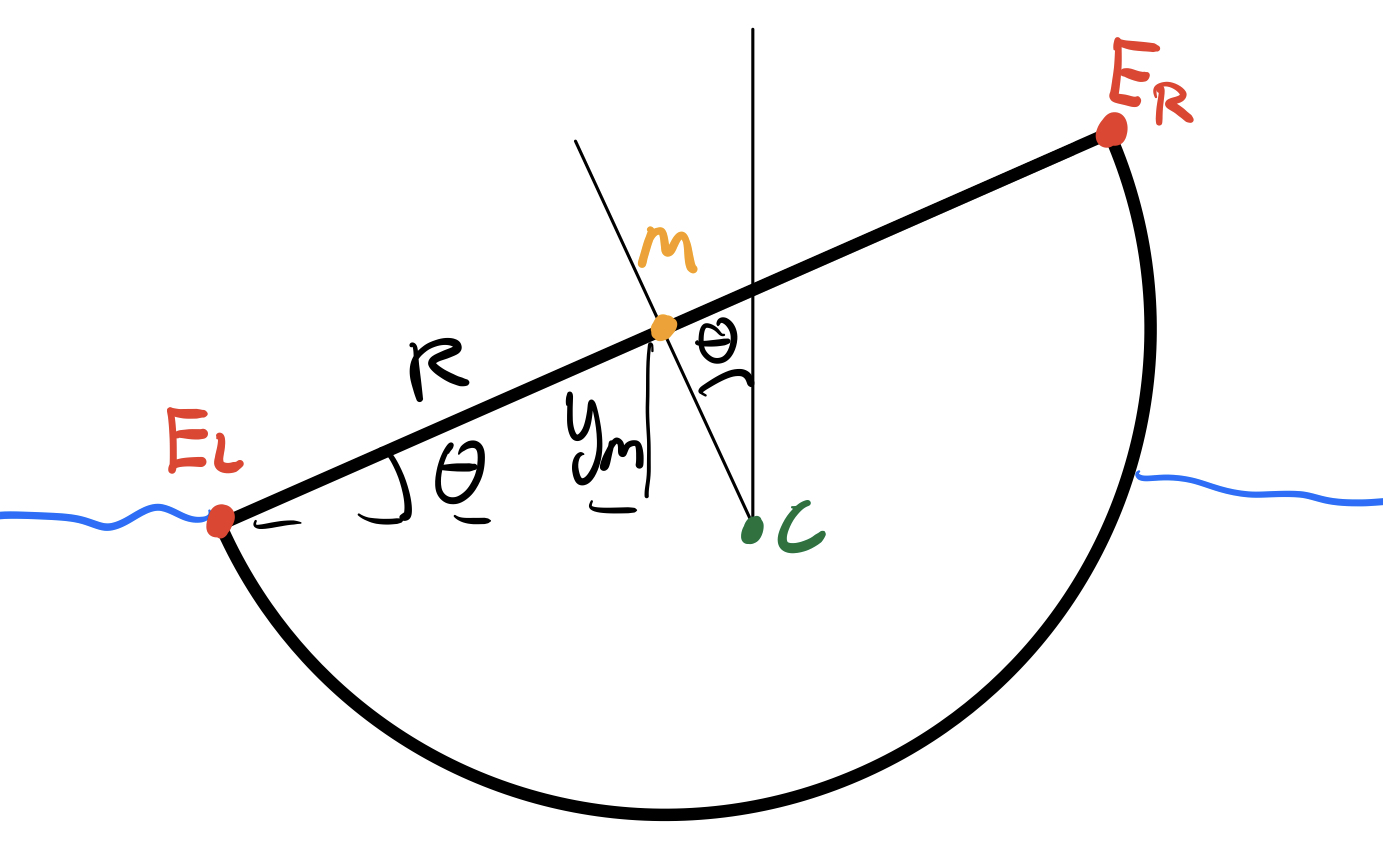
</div>

To see if our boat has capsized we keep track of the y-coordinate of the left and right endpoints $E_L$ and $E_R$:

$$
\begin{align}
    y_{E_L} &= y_M - R \sin{\theta} \\
    y_{E_R} &= y_M + R \sin{\theta}
\end{align}
$$


In [103]:
def boat_has_capsized(theta, yC):
    yM = find_yM(find_gamma(theta, yC))
    yEL = yM - R*np.sin(theta)
    yER = yM + R*np.sin(theta)
    return (yEL < 0 or yER < 0)

Introducing the vector 
$\vec{w} = \begin{bmatrix} \theta(t) & 
                           \omega(t) & 
                           x_C(t) & 
                           v_{C, x}(t) & 
                           y_C(t) & 
                           v_{C, y}(t) & 
                           s_L(t) & 
                           v_{L}(t)\end{bmatrix}^T$ 
we can write our problem on the standard form $\frac{\textrm{d}\vec{w}}{\textrm{d}t} = \vec f(t, \vec w) $:

$$ \frac{\textrm{d}}{\textrm{d}t} \begin{bmatrix} \theta(t) \\
                           \omega(t) \\
                           x_C(t) \\
                           v_{C, x}(t) \\
                           y_C(t) \\
                           v_{C, y}(t) \\
                           s_L(t) \\
                           v_{L}(t)\end{bmatrix} 
= \begin{bmatrix} \omega(t) \\ 
                  \Sigma\tau_C(t)/I_C \\
                  v_{C, x}(t) \\
                  \Sigma F_{C, x}(t)/m \\
                  v_{C, y}(t) \\
                  \Sigma F_{C, y}(t)/m \\
                  v_{L}(t)\\
                  \Sigma F_{L, \hat s}(t)/m\end{bmatrix}.$$


#################### DET OVER MÅ VISES MER??? OPPGAVE 1c) **HAR vist [nedenfor](#constA)**

## Code for visualization <a class="anchor" id="vis"></a>

A note on the animation-code ...

modified to save animations +++

blblb


In [104]:
import matplotlib.animation
from IPython.display import HTML, clear_output

'''Denne koden animerer bevegelsen til båtet, gitt at dere sender inn arrays som inneholder tidsverdier t,
skipets helningsvinkel theta, x- og y-koordinatet til skipets massesenter. Disse arraysene brukes i funksjonen
definert nederst "animate_deck_movement". Den grønne sirkelen viser posisjonen til skipets massesenter
Man kan sende inn optional argumenter, disse står beskrevet i funksjonen. For eksempel kan man sende inn et array
som inneholder lastens posisjon relativt metasenteret. Lasten vil da animeres som en rød sirkel.
'''

def animate_boat(t, theta, x_C, y_C, s_L=[], title="", gjerde=False, stepsize=0.01, vis_akse_verdier=False, gif_name = "TEST"):
    """
    brief: 
    :param t: Array som inneholder tidsverdiene man har beregnet \vec{w} for systemet
    :param theta: Array som inneholder utslagsvinkelen til skipet
    :param x_C: Array som inneholder massesenterets x-koordinat
    :param y_C: Array som inneholder massesenterets y-koordinat
    :param s_L: Optional array som inneholder lastens posisjon relativt massesenteret
    :param title: Update from "" to add a title
    :param gjerde: Optional Boolean som forteller om vi skal tegne inn gjerder på skipet
    :param stepsize: Hvor lang tid som skal gå mellom hver frame
    :param vis_akse_verdier: Hvis akse-verdier vises går animasjonen litt mer hakkete, men man kan se tallverdier
    :return: Animasjon som viser dynamikken til skipet
    """
    h     = t[1]-t[0]
    skips = int(0.1/h) # only care about 0.1 s intervals
    t, theta, x_C, y_C, s_L = t[::skips], theta[::skips], x_C[::skips], y_C[::skips], s_L[::skips]

    fig, ax = plt.subplots()
    boat,           = ax.plot([], [], color="k", linewidth=2)
    deck,           = ax.plot([], [], color="k", linewidth=2)
    sea_surface,    = ax.plot([-R*10, R* 10], [0, 0], color='blue', linewidth=2)  # The surface
    last,           = ax.plot([], [], color="r", marker="o", markersize=10)
    CM,             = ax.plot([], [], color="g", marker="o", markersize=10)
    MS,             = ax.plot([], [], color="y", marker="o", markersize=10)
    venstre_gjerde, = ax.plot([], [], color="k", marker="|", markersize=25)
    høyre_gjerde,   = ax.plot([], [], color="k", marker="|", markersize=25)
    ax.set_xlim([-R*1.3, R* 1.3])
    ax.set_ylim([-R*1.1, R* 1.1])
    ax.set_xlabel('$x$ [m]')
    ax.set_ylabel('$y$ [m]')
    ax.set_aspect("equal")
    textbox_theory = ax.text(3, 10, '', fontsize=12,
                             ha = 'left', va = 'top')
    plt.title(title)
                             
    # call this function for every frame in the animation
    def animate(M):
        ax.set_xlim([-R * 1.1 + np.amin(x_C), R * 1.1 + np.amax(x_C)])
        ax.set_ylim([-R*1.1, R* 1.1])
        angle_values = np.linspace(0, np.pi, 100)
        metasenter_x = x_C[M] - h_CM * np.sin(theta[M])
        metasenter_y = y_C[M] + h_CM * np.cos(theta[M])
        xs = R * np.cos(angle_values + np.pi + theta[M]) + metasenter_x
        ys = R * np.sin(angle_values + np.pi + theta[M]) + metasenter_y
        boat.set_data(xs, ys)
        deck.set_data([xs[0], xs[-1]], [ys[0], ys[-1]])
        if len(s_L) != 0:
            last.set_data(metasenter_x + s_L[M] * np.cos(theta[M]),
                          metasenter_y + s_L[M] * np.sin(theta[M]))
        CM.set_data(x_C[M], y_C[M])
        MS.set_data(metasenter_x, metasenter_y)
        if gjerde:
            venstre_gjerde.set_data([metasenter_x - R * np.cos(theta[M])], [metasenter_y - R * np.sin(theta[M])])
            høyre_gjerde.set_data([metasenter_x + R * np.cos(theta[M])], [metasenter_y + R * np.sin(theta[M])])
        theta_string= r'$\theta = %.2f$' % (theta[M] * 180 / np.pi) + r"$\degree$"
        time_string = '$t =  %.1f$' % (t[M])
        textbox_theory.set_text(
            theta_string + '\n' + time_string)

        if M % 1000 == 0:
            print(M)
        
    # create matplotlib animation object
    #inter = 1000*(t[1]-t[0]) # ms between frames
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t), repeat=False)
    frames_per_second = 1/(t[1]-t[0]) # ensure 1s on anim lasts 1s
    ani.save(f'animations/{gif_name}.gif', fps = frames_per_second)

Plotting ...

In [105]:
figure_count = 2566257 # To keep track of figure numbers
def plot_function(x_vals_list, y_vals_list, title = "",
    xlabel = r"$t$ [s]", ylabel = r"$\theta$ [rad]", labels = False,
    fig_text = False, fig_text_size = 15, fig_text_y = -0.04,
    title_size = 15, label_size = 15, fig_size = (9, 5), 
    loc = "upper right", file_title = False, 
    linestyles = False, set_xlim = False, set_ylim = False):
    """
    brief: 
    :param x_vals_list: 
    
    :return:
    """
    fig, ax = plt.subplots(figsize=fig_size)
    for i in range(len(y_vals_list)):
        if linestyles and len(linestyles) >= i+1:
            plt.plot(x_vals_list[i], y_vals_list[i], linestyles[i])
        else:
            plt.plot(x_vals_list[i], y_vals_list[i])
    plt.title(title, size = title_size)
    plt.xlabel(xlabel, size = label_size)
    plt.ylabel(ylabel, size = label_size)
    if labels:
        plt.legend(labels, loc=loc, prop={'size': label_size-2})
    if fig_text:
        global figure_count
        figure_count += 1
        txt = f"$Figure$ ${figure_count}$: " + fig_text
        plt.figtext(0.5, fig_text_y, txt, wrap=True, horizontalalignment='center', fontsize = fig_text_size)
    if set_xlim:
        ax.set_xlim(set_xlim)
    if set_ylim:
        ax.set_ylim(set_ylim)
    if file_title:
        fig.savefig(f'figures/{file_title}.png')
    plt.show()
    
def plot_function_dual(x_vals_list, y_vals_list, linestyles, titles = ["", ""],
    xlabels = [r"$t$ [s]", r"$t$ [s]"], ylabels = [r"$\theta$ [rad]", r"$\theta$ [rad]"],
    labels = [False, False], fig_text = False, fig_text_size = 15, fig_text_y = -0.04, title_size = 15, 
    label_size = 15, fig_size = (15, 5), loc = ["upper right", "upper right"], file_title = False):
    """
    brief: 
    :param x_vals_list: 
    
    :return:
    """
    fig, axs = plt.subplots(1, 2, figsize=fig_size)
    for i in range(len(axs)):
        for j in range(len(x_vals_list[i])):
            axs[i].plot(x_vals_list[i][j], y_vals_list[i][j], linestyles[i][j])
        axs[i].set_title(titles[i], size = title_size)
        if labels[i]:
            axs[i].legend(labels[i], loc=loc[i], prop={'size': label_size-2})
        axs[i].set_xlabel(xlabels[i], size = label_size)
        axs[i].set_ylabel(ylabels[i], size = label_size)

    if fig_text:
        global figure_count
        figure_count += 1
        txt = f"$Figure$ ${figure_count}$: " + fig_text
        plt.figtext(0.5, fig_text_y, txt, wrap=True, horizontalalignment='center', fontsize = fig_text_size)
    if file_title:
        fig.savefig(f'figures/{file_title}.png')
    plt.show()

## Harmonic oscillator with constant $A$ <a class="anchor" id="constA"></a>

**System equation when assuming constant water-displacement**

We begin our modelling of the boat with a very simple model. We assume that the centre of mass stays fixed and ignore all forces but the bouyancy. $C$ remains fixed by pretending that the displaced area $A$ is constant and equal to $A_0$.Thus $\Sigma F_y = F_B - F_G = 0$. Only the torque from the bouyancy, $\tau_B$, contributes to motion. Our system is described by:

$$
I_C \alpha(t) = \tau_B(t).
$$

Introdusing the angular velocity $\omega$ we can rewrite the second order ODE to a system of first order ODE's:

$$
\begin{align*}
\frac{\textrm{d}\theta}{\textrm{d}t} &= \omega \\
\frac{\textrm{d}\omega}{\textrm{d}t} &= \alpha = \tau_B(t)/I_C.
\end{align*}
$$

With the initial conditions $v_{C, x} = v_{C, y} = x_C = 0$ and $y_C = y_C^0$ all other variables remain constant, and our system can be written:

$$ \frac{\textrm{d}}{\textrm{d}t} \begin{bmatrix} \theta(t) \\
                           \omega(t) \\
                           x_C(t) \\
                           v_{C, x}(t) \\
                           y_C(t) \\
                           v_{C, y}(t) \\
                           s_L(t) \\
                           v_{L}(t)\end{bmatrix} 
= \begin{bmatrix} \omega(t) \\ 
                  \tau_B(t)/I_C \\
                  0 \\
                  0 \\
                  0 \\
                  0 \\
                  0 \\
                  0 \end{bmatrix}.$$

In [106]:
def f_harmonic_oscillator(t, w):
    """
    brief: the derivative of the vector w = [theta, omega]
           only including the harmonic restorative buoyant force
    :param theta: current angle
    :param omega: current angular velocity
    :return: the derivative
    """
    tau_B = find_tau_buoyant(w[0], find_F_buoyant(find_A(beta)))
    return np.array([w[1], tau_B/I_C, 0, 0, 0, 0, 0, 0])

**Eulers method and the ODE-solver**

Below we implement Eulers method discussed in ***REF***. When implementing the ODE-solver we include the possibility that the boat capsizes right away using our function from ***REF***. 

In [107]:
def euler_method(f, t, w, h):
    """
    brief: One step of Eulers method
    :param f: the function f(t, w)
    :param t: current t-value
    :param w: current w-value
    :param h: stepsize
    :return: the next value for tn and wn
    """
    t_next = t + h
    w_next = w + h*f(t, w)
    return t_next, w_next

def ode_solver(f, t0, t_end, w0, h0, method=euler_method):
    """
    brief: Solves the ode w' = f(t, w) with method of choice
    :param f: the function f(x)
    :param t0: initial t-value
    :param t_end: the final t-value
    :param w0: initial w-value
    :param h: stepsize
    :param method: the method used in each step
    :return: the next value for tn and wn
    """
    #Create arrays to store values
    t_num = np.array([t0])    
    w_num = np.array([w0])    

    # Values that are updated for each iteration
    tn = t0                
    wn = w0 
    h  = h0 #updated in last step
    
    # Main loop
    capsized = boat_has_capsized(wn[0], wn[2])
    while tn < t_end - 1.e-10: # Buffer for truncation errors        
    
        if not capsized:
            capsized = boat_has_capsized(wn[0], wn[4])

        if t_end - tn < h:
            h = t_end - tn
        
        if capsized:
            tn += h
            wn = np.array([np.pi/2 * np.sign(wn[0]), 0, wn[2], 0, max(-R, wn[4]-0.2), 0, 0, 0])
        else:
            tn, wn = method(f, tn, wn, h) # Do last step             

        # Add values to array
        t_num = np.append(t_num,tn)
        w_num = np.concatenate((w_num, np.array([wn])))
      
    return t_num, np.transpose(w_num)

**Finding appropriate stepsize with Eulers method**

Now that we have implementet our solver it is time to test it with different stepsizes $h$. We start the ship at $\theta_0 = 20^\circ$ and $\omega_0 = 0$. We start the iterations at $t=0\textrm{ s}$ and let it run for $20 \textrm{s}$.

In [108]:
# 1d) 

t0, t_end = 0, 20
# w0 = np.array([20*np.pi/180, 0, 0, 0, yC0, 0, 0, 0]) #[theta0, omega0, x0, vx0, y0, vy0, s0, vs0]
# times, thetas = [], []
# h_list = [0.01, 0.001, 0.0001]
# for h in h_list:
#     t_num, w_num = ode_solver(f_harmonic_oscillator, t0, t_end, w0, h, method=euler_method)
#     times.append(t_num)
#     thetas.append(w_num[0])
# #     animate_boat(t_num, w_num[0], w_num[2], w_num[4], 
# #                  title = f"$h$ = {h}", gif_name = f"HO_h={h}")  

# plot_function(times, thetas, fig_text = r"$\theta(t)$ for our simplest model, solved at different stepsizes $h$ with Eulers method.", 
#     fig_text_y = -0.1, linestyles = ['r', 'b', 'g'], labels = [f"$h$ = {h}" for h in h_list], loc = "upper left", set_ylim = [-0.4, 0.7])

The plot clearly shows that $h=0.01$ is not sufficient; the boat capsizes. With $h=0.001$ and $h=0.0001$ the difference in amplitudes is barely visible. We conclude that $0.001$ is a good stepsize; the error is barely notable and the runtime is good. 

<a class="anchor" id="anim1"></a>

| | |
:-------------------------:|:-------------------------:
![](animations/HO_h=0.01.gif) | ![](animations/HO_h=0.001.gif)

*Animation 1: Boat capsizing due to insufficient stepsize.*


**Small angle approximation**

We take some time to test the accuracy of the small angle approximation $\sin \theta \approx \theta$. The torque from the bouyant force becomes:

$$
\vec \tau_{B, SA} = -F_B h_{CM} \theta \hat z\\
$$

We define this force and the corresponding system-equation below:

In [109]:
#1e
def find_tau_buoyant_small_angle(theta, F_B):
    return - F_B*h_CM*theta

def f_harmonic_approxilator(t, w):
    """
    brief: the derivative of w only including the harmonic restorative 
           buoyant force, now with small angle approximation
    :param t: current time
    :param w: 8D array with current theta, omega, x, vx, y, vy, s, vs
    :return: 8D array with derivatives of the above parametres
    """
    tau_B = find_tau_buoyant_small_angle(w[0], find_F_buoyant(find_A(beta)))
    return np.array([w[1], tau_B/I_C, 0, 0, 0, 0, 0, 0])

To test its accuracy we run the same simulation as before with the starting angles $1°$ and $20°$:

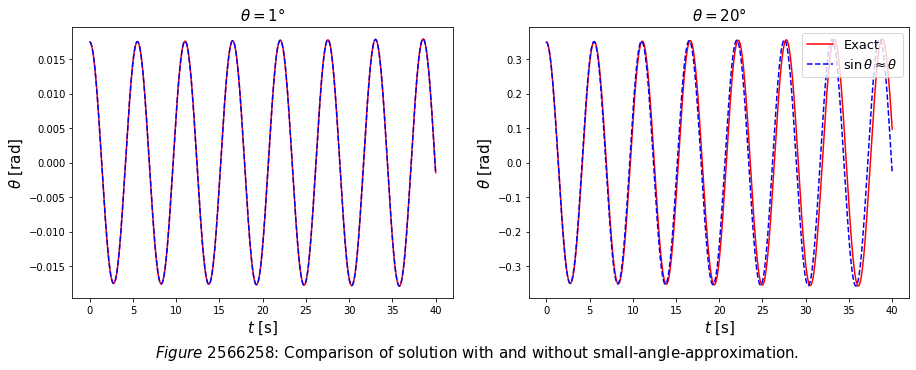

In [110]:
t_end = 40
h = 0.001
Theta_deg = [1, 20]
Theta = [thet*np.pi/180 for thet in Theta_deg]
x_vals_list = []
y_vals_list = []
for theta0 in Theta:
    w0 = [theta0, 0, yC0, 0, 0, 0, 0, 0]
    
    t_exact, w_exact   = ode_solver(f_harmonic_oscillator, t0, t_end, w0, h, method=euler_method)
    t_approx, w_approx = ode_solver(f_harmonic_approxilator, t0, t_end, w0, h, method=euler_method)   
    
    x_vals_list.append([t_exact, t_approx])
    y_vals_list.append([w_exact[0], w_approx[0]])
    
plot_function_dual(x_vals_list, y_vals_list, [['r', 'b--'], ['r', 'b--']], 
    titles = [r"$\theta=$" + f"{Theta_deg[0]}\u00B0", r"$\theta=$" + f"{Theta_deg[1]}\u00B0"], 
    fig_text = "Comparison of solution with and without small-angle-approximation.", 
    labels = [False, ["Exact", r"$\sin{\theta}\approx \theta$"]])

The figure shows that there is no significant difference at $\theta=1°$. At $20°$ the period is too small. This is because $\theta > \sin\theta$. Thus the restoriative force in the harmonic oscillator is overestimated using the approximation.

**The classic Runge Kutta method and global error**

We now implement the RK4 method discussed in ***REF***:

In [111]:
# 1f

def RK4_method(f, t, w, h):
    """
    brief: One step of RK4 method
    :param f: the function f(t, w)
    :param t: current t-value
    :param w: current w-value
    :param h: stepsize
    :return: the next value for tn and wn
    """
    k1 = f(t, w)
    k2 = f(t + h/2, w + h*k1/2)
    k3 = f(t + h/2, w + h*k2/2)
    k4 = f(t + h, w + h*k3)    
    
    t_next = t + h
    w_next = w + h/6*(k1 + 2*k2 + 2*k3 + k4)
    return t_next, w_next

**Analytic solution with the small angle approximation**

With the small angle approximation $\sin{\theta}\approx\theta$ our equation became:

$$
\begin{align*}
I_C\ddot{\theta} &= - F_B h_{CM} {\theta} = 0\\
\ddot{\theta} + \frac{F_B h_{CM}}{I_C} {\theta} &= 0.\\
\end{align*}
$$

With the initial conditions $\tilde\theta(0)=\theta_0, \, \tilde\omega(0)=0$ it has the analytic solution:

$$
\tilde{\theta} (t) = \theta_0 cos\left(\omega_0 t\right), \,\,\,\, \omega_0 = \sqrt{\frac{F_B h_{CM}}{I_C}}.
$$

We can use this to investigate how the global error $E_G$ depends on our stepsize $h$. We begin by defining the analytic solution:

In [112]:
# 1g
def find_omega_0(F_B):
    return np.sqrt(F_B*h_CM/I_C)

def analytic_harmonic_oscillator(time_array, theta0):
    F_B = find_F_buoyant(find_A(beta))
    omega_HO = find_omega_0(F_B)
    return theta0*np.cos(omega_HO*time_array)

**Error and order of methods**

We now iterate over different stepsizes $h$, and plot $\log{E_G}$ as a function of $\log{h}$.

  0%|          | 0/97 [00:00<?, ?it/s]

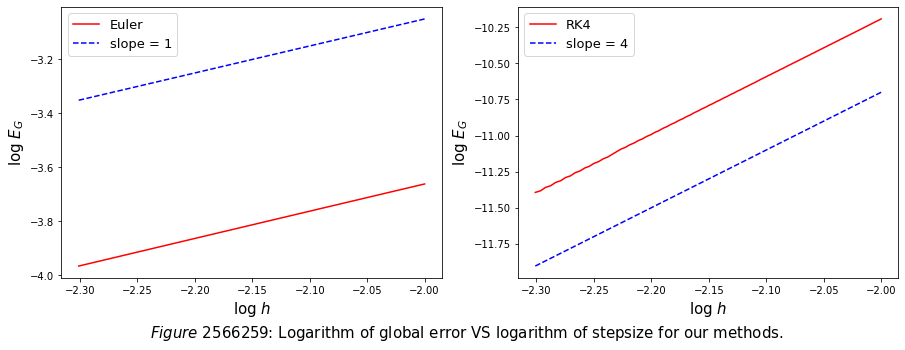

In [113]:
#1h

N = 97
h_array = np.linspace(1e-2, 5e-3, N)
global_error_euler = np.zeros(N)
global_error_RK4   = np.zeros(N)
w0 = [0.01, 0, 0, 0, yC0, 0, 0, 0] # [theta0, omega0, x0, vx0, y0, vy0, s0, vs0]

for i in tqdm(range(len(h_array))):
    h = h_array[i]
    theta_anal  = analytic_harmonic_oscillator(t_end, w0[0])
    o, w_euler = ode_solver(f_harmonic_approxilator, t0, t_end, w0, h, method=euler_method)
    o, w_RK4   = ode_solver(f_harmonic_approxilator, t0, t_end, w0, h, method=RK4_method)
    global_error_euler[i] = np.abs(theta_anal - w_euler[0][-1])
    global_error_RK4[i]   = np.abs(theta_anal - w_RK4[0][-1])

log_euler = np.log10(global_error_euler)
log_RK4   = np.log10(global_error_RK4)
log_h     = np.log10(h_array)

x_vals_list = [[log_h,     log_h],     [log_h,   log_h]]
y_vals_list = [[log_euler, log_h - 1.05], [log_RK4, 4*log_h-2.7]]
fig_txt = "Logarithm of global error VS logarithm of stepsize for our methods."

plot_function_dual(x_vals_list, y_vals_list, [['r', 'b--'], ['r', 'b--']], 
    labels = [["Euler", "slope = 1"], ["RK4", "slope = 4"]], xlabels = [r'log $h$', r'log $h$'],
    ylabels=[r'log $E_G$', r'log $E_G$'], fig_text = fig_txt, loc = ["upper left", "upper left"],
    title_size=25)

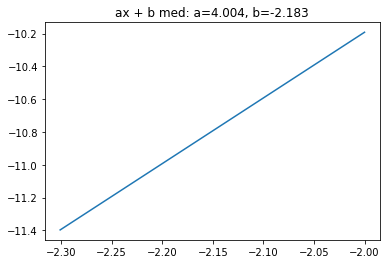

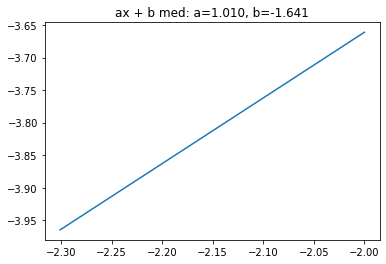

In [114]:
from scipy.optimize import curve_fit

def linear_regression(xvals, yvals):
    def func(x, a, b):
        return a*x+b

    popt, pcov = curve_fit(func, xvals, yvals)
    a, b = popt
    plt.figure()
    plt.plot(xvals, func(xvals, *popt))
    plt.title('ax + b med: a=%.3f, b=%.3f' % (a, b))
    
linear_regression(log_h, log_RK4)
linear_regression(log_h, log_euler)

**VI MÅ SE PÅ ØVINGA DER MAN FINNER ORDEN GRAFISK...**

As discussed in ***REF METHOD SECTION*** the global error is proportional to $h^{\textrm{order}}$. Plotting $\log\textrm{(error)}$ vs $\log h$ should give a straight line with a slope equal to the order of the method. 

MER

MER

??



## Varying displaced-water-area <a class="anchor" id="water"></a>

**Varying displaced-water-area**

We will now include the effect of changing the area of displaced water. The boyant force is no longer constant and equal to $F_G$, so $y_C$ is subject to change. Our system becomes

$$ \frac{\textrm{d}}{\textrm{d}t} \begin{bmatrix} \theta(t) \\
                           \omega(t) \\
                           x_C(t) \\
                           v_{C, x}(t) \\
                           y_C(t) \\
                           v_{C, y}(t) \\
                           s_L(t) \\
                           v_{L}(t)\end{bmatrix} 
= \begin{bmatrix} \omega(t) \\ 
                  \tau_B(t)/I_C \\
                  0 \\
                  0 \\
                  v_{C, y}(t) \\
                  (F_B(t)-F_G)/m \\
                  0\\
                  0\end{bmatrix}.$$


In [115]:
# 2a

def f_bouncing(t, w):
    """
    brief: the derivative of the vector w, now accounting for variations in displaced waterar
    :param t: current time
    :param w: 8D array with current theta, omega, x, vx, y, vy, s, vs
    :return: 8D array with derivatives of the above parametres
    """
    gamma = find_gamma(w[0], w[4])
    A     = find_A(gamma)
    F_B   = find_F_buoyant(A)
    tau_B = find_tau_buoyant(w[0], F_B)
    
    dtheta = w [1]
    domega = tau_B/I_C
    dy_C   = w [5]
    dv_Cy  = (F_B + F_G())/m
    return np.array([dtheta, domega, 0, 0, dy_C, dv_Cy, 0, 0])

In [116]:
# 2b

t0 = 0
t_end = 20
h = 0.001
w0 = [20*np.pi/180, 0, 0, 0, 0, 0, 0, 0]

t_vals_HO, w_vals_HO = ode_solver(f_harmonic_oscillator, t0, t_end, w0, h, method=RK4_method)
t_vals_bounce, w_vals_bounce = ode_solver(f_bouncing, t0, t_end, w0, h, method=RK4_method)

# vals = solve_ivp(f_harmonic_oscillator, (t0, t_end), w0, max_step=1.0e-2)
# t_vals_HO, w_vals_HO = vals.t, vals.y
# vals = solve_ivp(f_bouncing, (t0, t_end), w0, max_step=1.0e-2)
# t_vals_bounce, w_vals_bounce = vals.t, vals.y

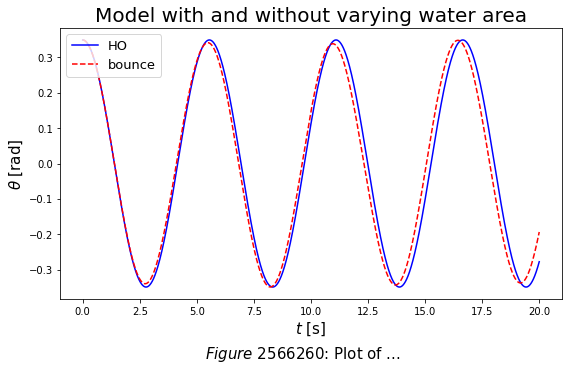

In [117]:
plot_function([t_vals_HO, t_vals_bounce], [w_vals_HO[0], w_vals_bounce[0]], 
              title = f"Model with and without varying water area",
              fig_text = "Plot of ...", linestyles = ['b', 'r--'], title_size=20,
              labels = ["HO", "bounce"], loc = "upper left")

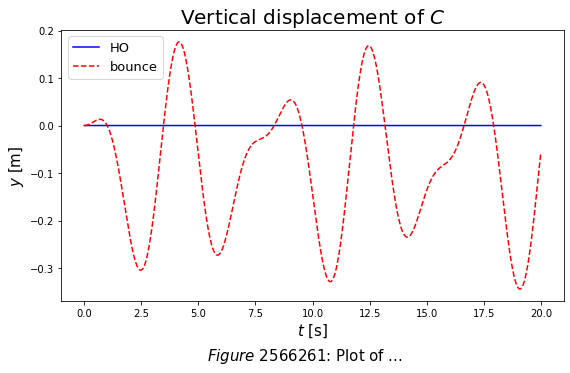

In [118]:
plot_function([t_vals_HO, t_vals_bounce], [w_vals_HO[4], w_vals_bounce[4]], 
              title = r"Vertical displacement of $C$",
              fig_text = "Plot of ...", linestyles = ['b', 'r--'], title_size=20,
              ylabel = r"$y$ [m]", labels = ["HO", "bounce"], loc = "upper left")

**WHY is vary A behind?? explain, y variation +++** 
y is deep when angle big. Big response ... Faster return... also lower amplitude...

In [119]:
# animate_boat(t_vals_HO, w_vals_HO[0], w_vals_HO[2], w_vals_HO[4], title = f"Constant $A$", gif_name = f"constant_A")
# animate_boat(t_vals_bounce, w_vals_bounce[0], w_vals_bounce[2], w_vals_bounce[4], title = f"Varying $A$", gif_name = f"varying_A")

<a class="anchor" id="anim1"></a>

| | |
:-------------------------:|:-------------------------:
![](animations/constant_A.gif) | ![](animations/varying_A.gif)


## Boat with cargo <a class="anchor" id="cargo"></a>

**FINNE LIKEVEKT PÅ NYTT?!?!** 

**VI KAN JO FORKLARE BETINGELSENE FOR LIKEVEKT OG HVA DE ULIKE STØRRELSENE BLIR I LIKEVEKT, OG FORKLARE HVORFOR VI BRUKER DE GAMLE I MODELLEN**

In [120]:
# def equilibrium_with_cargo(m_L):
    
    
    
    
#     return beta_cargo, 

**Equation for a ship with cargo**

1.4439272206683464

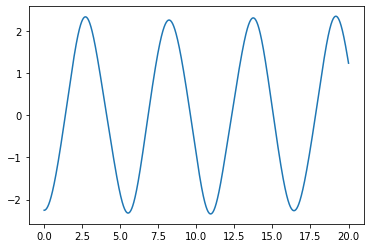

In [121]:
### JUStify that the cargo is always in contact with the deck:
# This reduces the description of the cargo to a 1D problem ...

plt.plot(t_vals_bounce, 1/2*R*np.gradient(w_vals_bounce[1])/h)

np.average(abs(1/2*R*np.gradient(w_vals_bounce[1])/h))

Adding the cargo our system becomes:

$$ \frac{\textrm{d}}{\textrm{d}t} \begin{bmatrix} \theta(t) \\
                           \omega(t) \\
                           x_C(t) \\
                           v_{C, x}(t) \\
                           y_C(t) \\
                           v_{C, y}(t) \\
                           s_L(t) \\
                           v_{L}(t)\end{bmatrix} 
= \begin{bmatrix} \omega(t) \\ 
                  (\tau_B(t)+\tau_L(t))/I_C \\
                  v_{C, x}(t) \\
                  F_{L, x}(t) / m \\
                  v_{C, y}(t) \\
                  (F_B(t)+F_G+F_{L, y}(t))/m \\
                  v_{L}(t)\\
                  -g\sin{\theta(t)}\end{bmatrix}.
$$

**Ship without fences**

We begin by allowing the cargo to fall of the ship. When this happens $m_L$ is set to zero so that it will no longer affect the motion of the ship. 
                  

In [122]:
def f_cargo_without_fence(t, w):
    """
    brief: the derivative of the vector w, now including cargo that can fall off
    :param t: current time
    :param w: 8D array with current theta, omega, x, vx, y, vy, s, vs
    :return: 8D array with derivatives of the above parametres
    """
    gamma = find_gamma(w[0], w[4])
    A     = find_A(gamma)
    F_B   = find_F_buoyant(A)
    F_Ly  = find_F_Ly(w[0])
    F_Lx  = find_F_Lx(w[0])
    tau_B = find_tau_buoyant(w[0], F_B)
    tau_L = find_tau_L (w[0], w[6])
    
    global m_L
    if abs(w[6]) > R:
        m_L = 0
        dv_L = 0
    else:
        dv_L = -g*np.sin(w[0])
        
    dtheta = w[1]
    domega = (tau_B+tau_L)/I_C
    dx_C   = w[3]
    dv_Cx  = F_Lx/m
    dy_C   = w[5]
    dv_Cy  = (F_B + F_G() + F_Ly)/m
    ds_L   = w[7]     
    
    return np.array([dtheta, domega, dx_C, dv_Cx, dy_C, dv_Cy, ds_L , dv_L])

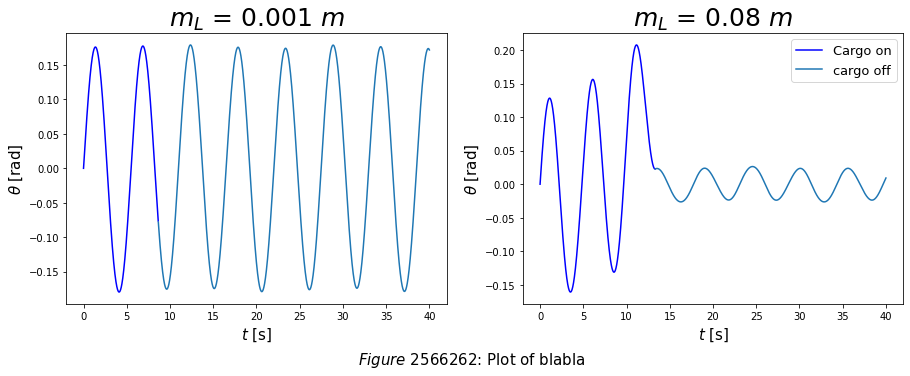

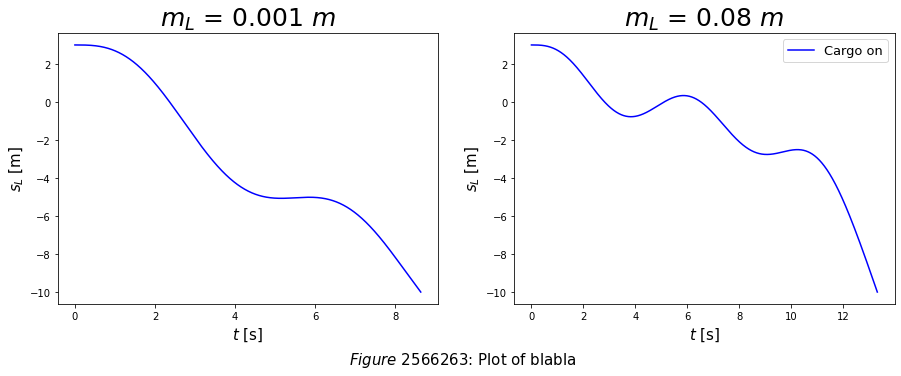

In [123]:
def find_cargo_offboard(s_L): 
    """
    #returns: index of which cargo falls off board, zero if cargo stays on board the whole time
    
    """
    for i in range(len(s_L)):
        if abs(s_L[i]) > R:
            return i
    return -1

t0    = 0
t_end = 40
h = 0.01
w0 = [0, 0.2, 0, 0, 0, 0, 3, 0]

times  = []
thetas = []
s_Ls   = []

m_L_factor_list = [0.001, 0.08]
for i in range(len(m_L_factor_list)):
    m_L = m_L_factor_list[i] * m
    t_vals, w_vals = ode_solver(f_cargo_without_fence, t0, t_end, w0, h, method=RK4_method)
    cargo_offboard = find_cargo_offboard(w_vals[6])
    
    times.append([t_vals[0:cargo_offboard], t_vals[cargo_offboard::]])
    thetas.append([w_vals[0][0:cargo_offboard], w_vals[0][cargo_offboard::]])
    s_Ls.append([w_vals[6][0:cargo_offboard]])
    
#     animate_boat(t_vals, w_vals[0], w_vals[2], w_vals[4], w_vals[6], 
#     title = r"$m_L=$ " + f"{m_L_factor_list[i]} $m$", gif_name = f"no_fence_mL={m_L_factor_list[i]}m")  
    
plot_function_dual(times, thetas, [['b', 'tab:blue'], ['b', 'tab:blue']], titles = 
                   [f"$m_L$ = {m_L_factor_list[0]} $m$", f"$m_L$ = {m_L_factor_list[1]} $m$"""], 
                   labels = [False, ["Cargo on", "cargo off"]], 
                   fig_text = "Plot of blabla", 
                   loc = ["upper right", "upper right"], title_size=25)    
   
plot_function_dual([[times[0][0]], [times[1][0]]], s_Ls, [['b', 'tab:blue'], ['b', 'tab:blue']], 
                   [f"$m_L$ = {m_L_factor_list[0]} $m$", f"$m_L$ = {m_L_factor_list[1]} $m$"""], 
                   labels = [False, ["Cargo on", "cargo off"]], ylabels = [f"$s_L$ [m]", f"$s_L$ [m]"],
                   fig_text = "Plot of blabla", 
                   loc = ["upper right", "upper right"], title_size=25)    

Discuss - **WHY very damped with big cargo? It leaves with a lot of the ships enegy??**

<a class="anchor" id="anim1"></a>

| | |
:-------------------------:|:-------------------------:
![](animations/no_fence_mL=0.001m.gif) | ![](animations/no_fence_mL=0.08m.gif)


**Ship with fences**

We ignore the change in momentum from the cargo hitting the fences, and the fact that while the cargo is at the fence the force on the ship changes (the normal force is only up **?????????????** )

In [124]:
def f_cargo_with_fence(t, w):
    """
    brief: the derivative of the vector w, now including cargo that is stopped at edges
    :param t: current time
    :param w: 8D array with current theta, omega, x, vx, y, vy, s, vs
    :return: 8D array with derivatives of the above parametres
    """
    gamma = find_gamma(w[0], w[4])
    A     = find_A(gamma)
    F_B   = find_F_buoyant(A)
    F_Ly  = find_F_Ly(w[0])
    F_Lx  = find_F_Lx(w[0])
    tau_B = find_tau_buoyant(w[0], F_B)
    tau_L = find_tau_L (w[0], w[6])
    
    dtheta = w[1]
    domega = (tau_B+tau_L)/I_C
    dx_C   = w[3]
    dv_Cx  = F_Lx/m
    dy_C   = w[5]
    dv_Cy  = (F_B + F_G() + F_Ly)/m 
    
    if abs(w[6]) > R and w[6]*w[7] > 0:
        ds_L = 0
        w[7] = 0
    else:
        ds_L = w[7]
    dv_L = -g*np.sin(w[0])
        
    return np.array([dtheta, domega, dx_C, dv_Cx, dy_C, dv_Cy, ds_L , dv_L])

In [125]:
times  = []
thetas = []
s_Ls   = []

m_L_factor_list = [0.001, 0.08]
for i in range(len(m_L_factor_list)):
    m_L = m_L_factor_list[i] * m
    t_vals, w_vals = ode_solver(f_cargo_with_fence, t0, t_end, w0, h, method=RK4_method)
    cargo_offboard = find_cargo_offboard(w_vals[6])
    
    times.append([t_vals[0:cargo_offboard], t_vals[cargo_offboard::]])
    thetas.append([w_vals[0][0:cargo_offboard], w_vals[0][cargo_offboard::]])
    s_Ls.append([w_vals[6][0:cargo_offboard]])
    
#     animate_boat(t_vals, w_vals[0], w_vals[2], w_vals[4], w_vals[6], title = r"$m_L=$ " + f"{m_L_factor_list[i]} $m$", 
#                  gif_name = f"fence_mL={m_L_factor_list[i]}m", gjerde = True)  
    
# FIGURE OUT WHAT WE WANT TO PLOT

<a class="anchor" id="anim1"></a>

| | |
:-------------------------:|:-------------------------:
![](animations/fence_mL=0.001m.gif) | ![](animations/fence_mL=0.08m.gif)


**WHAT TO PLOT???**

## Boat with friction and harmonic wave/wind-force <a class="anchor" id="w-force"></a>

In [126]:
# 2f + 2g
def f_wind_friction(t, w):
    """
    brief: the derivative of the vector w, now without cargo with 
    friction and harmonic wawe/wind force
    :param t: current time
    :param w: 8D array with current theta, omega, x, vx, y, vy, s, vs
    :return: 8D array with derivatives of the above parametres
    NB: k_f, F_0 og omega_w must be defined before calling the function
    """
    
    gamma = find_gamma(w[0], w[4])
    A     = find_A(gamma)
    F_B   = find_F_buoyant(A)
    tau_B = find_tau_buoyant(w[0], F_B)
    f     = find_F_friction(gamma, w[1], k_f)
    tau_f = find_tau_friction(w[4], gamma, f)
    F_w   = find_F_waves_wind(t, F_0, omega_w)
    tau_w = find_tau_waves_wind(w[4], F_w)
    
    dtheta = w[1]
    domega = (tau_B + tau_f + tau_w)/I_C
    dx_C   = w[3]
    dv_Cx  = (f + F_w)/m
    dy_C   = w[5]
    dv_Cy  = (F_B + F_G())/m
    return np.array([dtheta, domega, dx_C, dv_Cx, dy_C, dv_Cy, 0, 0])

**Calm waters**

We first assume ...

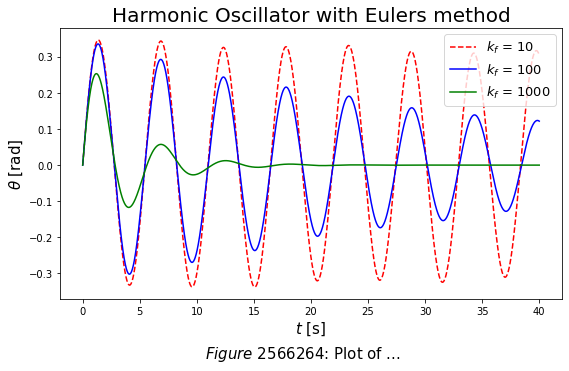

In [127]:
# 2f

t0    = 0
t_end = 40
h     = 0.01
w0 = [0, 0.4, 0, 0, yC0, 0, 0, 0]
F_0, omega_w = 0, 0 # Calm waters before the storm (:
k_f_list = [10, 100, 1000]

times  = []
thetas = []
for i in range(len(k_f_list)):
    k_f = k_f_list[i]
    t_vals, w_vals = ode_solver(f_wind_friction, t0, t_end, w0, h, method=RK4_method)
    times.append(t_vals)
    thetas.append(w_vals[0])

#     animate_boat(t_vals, w_vals[0], w_vals[2], w_vals[4], w_vals[6], title = r"$k_f=$ " + f"{k_f}", gif_name = f"water_friction_kf={k_f}")  
       
plot_function(times, thetas, title = f"Harmonic Oscillator with Eulers method",
              fig_text = "Plot of ...", linestyles = ['r--', 'b', 'g'], title_size=20,
              labels = [r"$k_f$ = " + f"{k_f}" for k_f in k_f_list], loc = "upper right")


<a class="anchor" id="anim1"></a>

| | |
:-------------------------:|:-------------------------:
![](animations/water_friction_kf=100.gif) | ![](animations/water_friction_kf=1000.gif)

  0%|          | 0/100 [00:00<?, ?it/s]

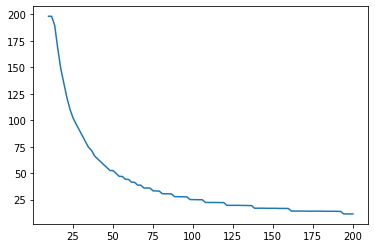

In [128]:
### INTERESSANT Å SE PÅ??
N = 100
k_f_array = np.linspace(10, 200, N)
half_time = np.zeros(N)
w0 = [0.3, 0, 0, 0, yC0, 0, 0, 0] # [theta0, omega0, x0, vx0, y0, vy0, s0, vs0]
h  = 0.1
t0 = 0
t_end = 200

for i in tqdm(range(N)):
    k_f = k_f_array[i]
    t_vals, w_vals = ode_solver(f_wind_friction, t0, t_end, w0, h, method=RK4_method)
    theta_amplitude = abs(w_vals[0])
    for j in range(len(t_vals)):
        if max(theta_amplitude[j::]) < 1/2 * w0[0]:
            half_time[i] = h*j
            break
                                                             
plt.plot(k_f_array, half_time)

## KANSKJE finne en bedre indikator på henfall... Her får vi hopp når det skjer en topp tidligere.

Harmo...

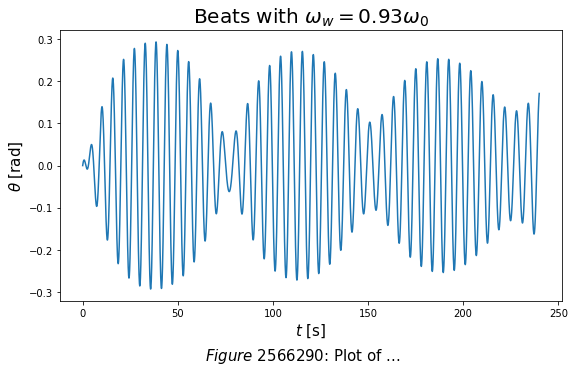

In [151]:
# 2g


t0 = 0
t_end = 240
h = 0.01
w0 = [0, 2*np.pi/180, 0, 0, yC0, 0, 0, 0]
k_f = 10
F_0 = 0.625*m*g
omega_w_scale_factor = 0.93
omega_w = omega_w_scale_factor*np.sqrt(m*g*h_CM/I_C)

t_vals, w_vals = ode_solver(f_wind_friction, t0, t_end, w0, h, method=RK4_method)
plot_function([t_vals], [w_vals[0]], title = r"Beats with $\omega_w=$" + f"{omega_w_scale_factor}" + r"$\omega_0$",
              fig_text = "Plot of ...", linestyles = [], title_size=20,
              labels = False, loc = "upper right")

# animate_boat(t_vals, w_vals[0], w_vals[2], w_vals[4], w_vals[6], 
#              title = r"$\omega_w=$ " + f"{omega_w_scale_factor}" + r"$\omega_0$", 
#              gif_name = f"beats_omega_w={omega_w_scale_factor}omega_0") 

![](animations/beats_omega_w=0.93omega_0.gif)

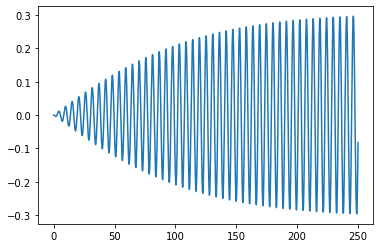

In [130]:

t0 = 0
t_end = 250
w0 = [0, 0, 0, 0, yC0, 0, 0, 0]
h = 0.01
F_0 = 0.1*m*g
omega_w_scale_factor = 1
omega_w = omega_w_scale_factor*np.sqrt(m*g*h_CM/I_C)
k_f = 10

t_vals, w_vals = ode_solver(f_wind_friction, t0, t_end, w0, h, method=RK4_method)

plt.plot(t_vals, w_vals[0])
plt.show()

## ÅPEN oppgave <a class="anchor" id="w-force"></a>

In [131]:
# 2h

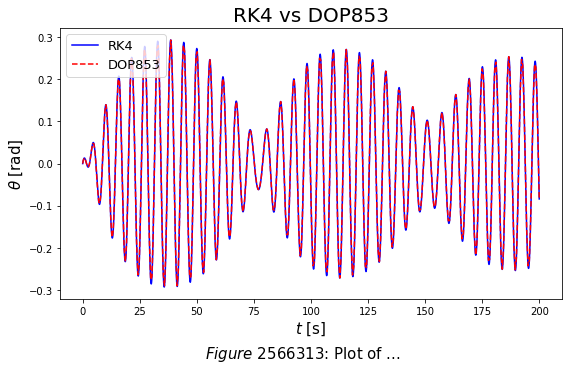

In [170]:
## FORSLAG 

# Gjøre løseren adaptiv

# Går det an å lage en stiv likning med båten???
    # SETT BÅTEN MELLOM 2 vegger??
    # Modellere veggen som en ideel fjær med k = 1000000000?
    
    #### Vakre forslag gutta. Implementerte en versjon i scipy, så vi kan sammenligne: 
    # Denne bruker RK45, så er adaptiv
    

from scipy.integrate import solve_ivp

t0 = 0
t_end = 200
h = 0.01
w0 = [0, 2*np.pi/180, 0, 0, yC0, 0, 0, 0]
k_f = 10
F_0 = 0.625*m*g
omega_w_scale_factor = 0.93
omega_w = omega_w_scale_factor*np.sqrt(m*g*h_CM/I_C)

t_RK4, w_RK4 = ode_solver(f_wind_friction, t0, t_end, w0, h, method=RK4_method)
vals = solve_ivp(f_wind_friction, (t0, t_end), w0, method='DOP853',  atol=1.0e-9, rtol=1.0e-6)
t_DOP853, w_DOP853 = vals.t, vals.y
vals = solve_ivp(f_wind_friction, (t0, t_end), w0, method='RK45',  atol=1.0e-9, rtol=1.0e-6)
t_RK45, w_RK45 = vals.t, vals.y


plot_function([t_RK4, t_DOP853], [w_RK4[0], w_DOP853[0]], 
              title = f"RK4 vs DOP853",
              fig_text = "Plot of ...", linestyles = ['b', 'r--'], title_size=20,
              labels = ["RK4", "DOP853"], loc = "upper left")
### Tror animasjon funker dårlig her... Vanskelig å få til at tid på anim stemmer med virkelighet når h varierer
# animate_boat(t_vals, w_vals[0], w_vals[2], w_vals[4], 
#          w_vals[6], title = r"$\omega_w=$ " + f"{omega_w_scale_factor}" + r"$\omega_0$", 
#          gif_name = f"scipy_implementation={omega_w_scale_factor}omega_0") 

## Conclusion <a class="anchor" id="conclusion"></a>

We have found, we have shown

## KODEBANK, søppel++

In [133]:
# def victor():
#     def func(x, y):
#         val = 2.8*x**2 * (x**2*(2.5*x**2+y**2-2)+1.2*y**2 * (y*(3*y-0.75)-6.0311)+3.09)+0.98*y**2 * ((y**2-3.01)*y**2+3)-1.005
#         return abs(val) < 0.02
#     n = 3000
#     x = np.linspace(-2, 2, n)
#     y = np.linspace(-2, 2, n)
#     grid = np.zeros((n, n))
#     y, x = np.meshgrid(x, y)
#     z = func(x, y)
#     z = z[:-1, :-1]
#     z_min, z_max = 0, 1
#     fig, ax = plt.subplots()
#     c = ax.pcolormesh(x, y, z, vmin=z_min, vmax=z_max)
#     ax.set_title('Viktooooor')
#     ax.axis([x.min(), x.max(), y.min(), y.max()])
#     fig.colorbar(c, ax=ax)
#     plt.show()

# victor()


Tyngdepunktet til vannet:


    I likevekt har vi:

$$
\begin{equation}
\mathbf{r} \equiv \begin{bmatrix}
y \\
\theta
\end{bmatrix}
\label{eq:vector_ray}
\end{equation}
$$

Vector **r** is defined by equation $\eqref{eq:vector_ray}$
$\eqref{eq:vector_ray}$

En vinkel $\theta$ og en forflytning $\Delta y$ fra likevekt har vi:
$$
\begin{align}
y_M(\theta ) &= R \cos{\beta/2} + (4R/3\pi)(\cos{\theta}-1) + \Delta y\\
y_M(\theta) &= R \cos{\beta/2} + (4R/3\pi)(\cos{\theta}-1) + \Delta y\\
y_M(\theta) &= R \cos{\beta/2} + (4R/3\pi)(\cos{\theta}-1) + \Delta y\\
y_M(\theta) &=69
\end{align}
$$




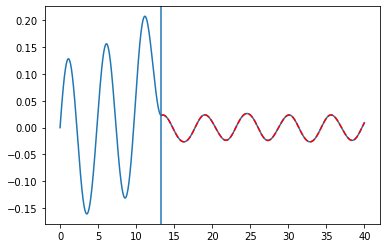

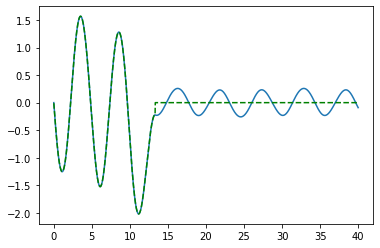

In [134]:
t_end = 40

w0 = [0, 0.2, 0, 0, 0, 0, 3, 0]
t0 = 0
t_end = 40
m_L =0.08*m
t_vals, w_vals = ode_solver(f_cargo_without_fence, t0, t_end, w0, h, method=RK4_method)
cargo_offboard = find_cargo_offboard(w_vals[6])

# animate_boat(t_vals[::10], w_vals[0][::10], w_vals[2][::10], w_vals[4][::10], w_vals[6][::10], 
#              gjerde = False, vis_akse_verdier = False, gif_name="heavy_no_fence")
# plt.show()

plt.plot(t_vals, w_vals[0])
if (cargo_offboard != 0):
    plt.axvline(t_vals[cargo_offboard])

t0 = t_vals[cargo_offboard+1]
w0 = np.transpose(w_vals)[cargo_offboard+1]
t2_vals, w2_vals = ode_solver(f_bouncing, t0, t_end, w0, h, method=RK4_method)
plt.plot(t2_vals, w2_vals[0], 'r--')
plt.show()


# plt.plot(t_vals, w_vals[6])
# if (cargo_offboard != 0):
#     plt.axvline(t_vals[cargo_offboard])
# plt.show()

# SER BRA UT
plt.plot(t_vals, -g*np.sin(w_vals[0]))
plt.plot(t_vals, np.gradient(w_vals[7])*1/h, "g--")


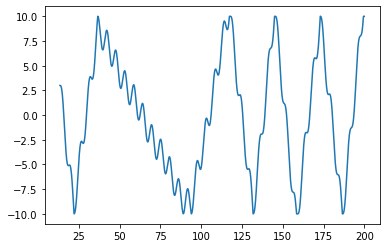

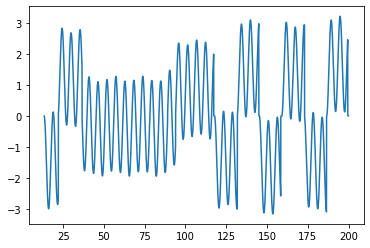

In [135]:

t_end = 200

w0 = [0, 0.2, 0, 0, 0, 0, 3, 0]
m_L = 0.00001*m
t_vals, w_vals = ode_solver(f_cargo_with_fence, t0, t_end, w0, h, method=RK4_method)
theta = w_vals[0]
s_L = w_vals[6]
#animate_boat(t_vals[::10], theta[::10], xC[::10], yC[::10], gjerde = True, vis_akse_verdier = False)

plt.plot(t_vals, w_vals[6])
plt.show()

plt.plot(t_vals, w_vals[7])
plt.show()


#animate_boat(t_vals[::10], w_vals[0][::10], w_vals[2][::10], w_vals[4][::10], w_vals[6][::10], gjerde = True, vis_akse_verdier = False, gif_name = "heavy")

# m_L =0.08*m
# t_vals, w_vals = ode_solver(f_cargo_with_fence, t0, t_end, w0, h, method=RK4_method)
# theta = np.transpose(w_vals)[0]
# s_L = np.transpose(w_vals)[6]

# plt.plot(t_vals, theta)
# plt.show()
# plt.plot(t_vals, s_L)
# plt.show()

# At = t_vals
# Atheta = np.transpose(w_vals)[0]
# Ax_C = np.transpose(w_vals)[2]
# Ay_C = np.transpose(w_vals)[4]
# As_L = np.transpose(w_vals)[6]
# animate_boat(At[::10], Atheta[::10], Ax_C[::10], Ay_C[::10], As_L, gjerde = True, vis_akse_verdier = False, gif_name = "heavy")

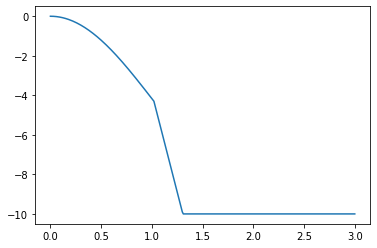

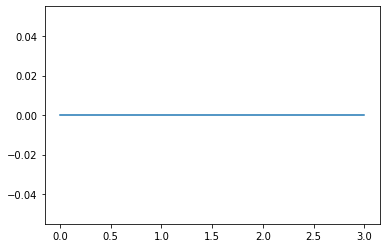

MovieWriter ffmpeg unavailable; using Pillow instead.


0
0


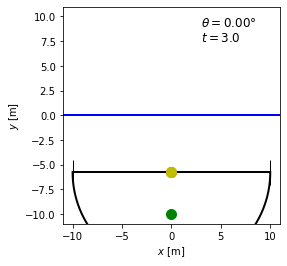

In [136]:
t0 = 0
t_end = 3

w0 = [0, 0, 0, 0, 0, 0, 0, 0]
m_L = 0.99*m
t_vals, w_vals = ode_solver(f_cargo_with_fence, t0, t_end, w0, h, method=RK4_method)
theta = w_vals[0]
s_L = w_vals[6]

plt.plot(t_vals, w_vals[4])
plt.show()

plt.plot(t_vals, w_vals[7])
plt.show()


animate_boat(t_vals, w_vals[0], w_vals[2], w_vals[4], w_vals[6], 
             gjerde = True, vis_akse_verdier = False, gif_name = "sink")


$\eqref{eq:HO_tau}$ **MÅ FINNE UT AV LIKNINGSNUMMER**

$$
\begin{equation}
\sum{\tau} = I_C \ddot{\theta} = \tau_C(\theta). \\
\label{eq:HO_tau}
\end{equation}
$$



We introduce the angular velocity $\omega = \dot{\theta}$ and split the problem into a system of first order equations:

$$
\begin{align*}
\frac{\textrm{d}\theta}{\textrm{d}t} &= \omega \\ 
\frac{\textrm{d}\omega}{\textrm{d}t} &= \frac{\tau_C(\theta)}{I_C}. \\
\end{align*}
$$

Introducing the vector $\vec{w} = \begin{bmatrix} \theta(t) & \omega(t) \end{bmatrix}^T$ we can write our problem on the standard form $\frac{\textrm{d}\vec{w}}{\textrm{d}t} = \vec f(t, \vec w) $:

$$ \frac{\textrm{d}}{\textrm{d}t} \begin{bmatrix} \theta(t) \\ \omega(t) \end{bmatrix} 
= \begin{bmatrix} \omega \\ - \frac{F_B h_{CM}}{I_C} \sin{\theta}\end{bmatrix}.$$

The variable $F_B$ is given by:

$$F_B = \sigma_0 A_0 g = \frac{\sigma_0gR^2}{2} (\beta - \sin{\beta}) $$ 